2025-03-24 16:12:17.162306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 16:12:17.169292: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 16:12:17.218172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 16:12:17.250522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742832737.289272    3075 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742832737.30

Found 18949 validated image filenames belonging to 4 classes.
Found 4738 validated image filenames belonging to 4 classes.


2025-03-24 16:12:20.377816: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/user/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 445s 744ms/step - accuracy: 0.5219 - loss: 2.0747 - val_accuracy: 0.6076 - val_loss: 0.8870
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 418s 704ms/step - accuracy: 0.5797 - loss: 1.0111 - val_accuracy: 0.6207 - val_loss: 0.8572
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 417s 702ms/step - accuracy: 0.5938 - loss: 0.9854 - val_accuracy: 0.6165 - val_loss: 0.8232
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 415s 700ms/step - accuracy: 0.6010 - loss: 0.9519 - val_accuracy: 0.6222 - val_loss: 0.8415
Epoch 5/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 416s 702ms/step - accuracy: 0.6232 - loss: 0.9069 - val_accuracy: 0.6427 - val_loss: 0.7720
Epoch 6/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 417s 704ms/step - accuracy: 0.6271 - loss: 0.8984 - val_accuracy: 0.6615 - val_loss: 0.7663
Epoch 7/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 442s 704ms/step - accuracy: 0.6267 - loss: 0.8862 - val_accuracy: 0.6541 - val_loss: 0.7622
Epoch 8/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 442s 705ms/step - accuracy: 0.6416 -

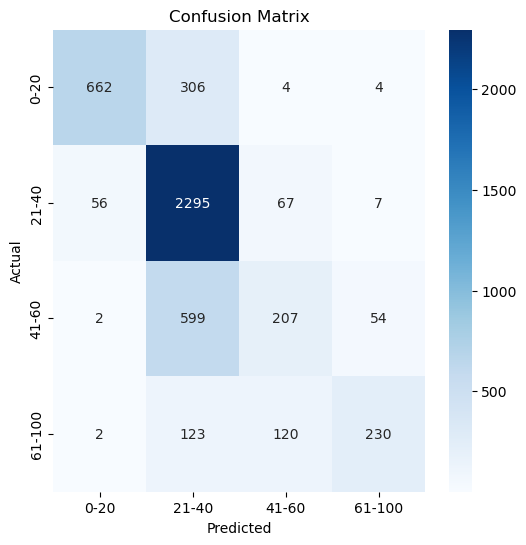

Classification Report:
               precision    recall  f1-score   support

        0-20       0.92      0.68      0.78       976
       21-40       0.69      0.95      0.80      2425
       41-60       0.52      0.24      0.33       862
      61-100       0.78      0.48      0.60       475

    accuracy                           0.72      4738
   macro avg       0.73      0.59      0.63      4738
weighted avg       0.72      0.72      0.69      4738



In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# Load dataset
DATASET_PATH = "/home/user/Age_Detection/UTKFace"  # Update with actual dataset path
image_size = (224, 224)

# Extract image filenames and labels
image_files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".jpg")]
ages = [int(f.split("_")[0]) for f in image_files]
data = pd.DataFrame({"filename": image_files, "age": ages})

# Age Binning (Optional - Categorizing into age groups)
data["age_category"] = pd.cut(data["age"], bins=[0, 20, 40, 60, 100], labels=["0-20", "21-40", "41-60", "61-100"])
data = data.dropna()

# Splitting Data
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data["age_category"], random_state=42)

# ImageDataGenerator for Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=DATASET_PATH, x_col='filename', y_col='age_category', target_size=image_size,
    class_mode='categorical', batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
    test_df, directory=DATASET_PATH, x_col='filename', y_col='age_category', target_size=image_size,
    class_mode='categorical', batch_size=32, shuffle=False)

# Load Pre-trained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)  # 4 Age Categories

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
epochs = 10
history = model.fit(train_generator, validation_data=test_generator, epochs=epochs)

# Evaluate Model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0-20", "21-40", "41-60", "61-100"],
            yticklabels=["0-20", "21-40", "41-60", "61-100"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["0-20", "21-40", "41-60", "61-100"]))
